# Facial Expression Comparison Network (FECNet)

Implementation of the paper:  
A Compact Embedding for Facial Expression Similarity  
http://openaccess.thecvf.com/content_CVPR_2019/html/Vemulapalli_A_Compact_Embedding_for_Facial_Expression_Similarity_CVPR_2019_paper  

## Description  

As Described in the paper, the propesed architecture serves as a feature extraction network that could be utilized in many classification tasks.  
Our goal is to use FECNet as a base model for Emotion Recognition and Drowsiness Detection algorithms.  
The implementation of FECNet could be divided into  parts:  
* Dataset input and preprocessing.
* Model architecture implementation.
* Loss function and metrics utility implementation.
* Model training.  

### Dataset input and preprocessing  

The raw dataset provided by the authors is an excel sheet with urls to the images, bounding boxes, class label and annotations. Please refer to the original paper for further details.  
The processed dataset consists of three folders each folder corresponding to an image set (cropped) of the triplets; the first folder has each first image of each triplet. 

### Model architecture implementation  

Unlike the proposed architecture, and due to unavailable public weights for FacenNt-NN2 architecture, we used FaceNet-inception-resnet-v1 architecture instead.  
Our proposed architecture is as follows:  
FaceNet-inception-resnet-v1 until block "Mixed_6a", followed by a Dense block and two fully connected layers as proposed by the original authors.

### Loss function and metrics utility implementation

As described by the authors the labels are one of three classes, please refer to the original paper for details.
As each triplet has 6 annotations that created variations in the ground truth estimate for the euclidean distances between each image in a triplet, we decided to make use of this variation and implemented a weighted triplets loss function.  
The weights mentioned are calculated by dividing the number of voters on each class over the total number of voters. Three contributing losses are calculated and then each loss is multiplied by its corresponding weight.  
Example:  
A triplet has the following annotations array: [1,2,2,2,3,3]. The weights array would then be: [1/6, 3/6, 2/6]. Then three loss values are calculated each one corresponding to one of the class labels; "1" label corresponds to that the first and third images are more similar. Then the three claculated weights are multiplied by the three calculated losses and the final loss is the summation.  
Metrics utility is trivial.


### Model training

This part is trivial and implemented as described by the authors.


In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.8682779709999977
GPU (s):
0.0542758180000078
GPU speedup over CPU: 34x


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Dataset Input And Preprocessing

In [ ]:
!unzip -q "/content/drive/My Drive/Datasets/FEC_cropped/C1.zip"

In [ ]:
!unzip -q "/content/drive/My Drive/Datasets/FEC_cropped/C2.zip"

In [ ]:
!unzip -q "/content/drive/My Drive/Datasets/FEC_cropped/C3.zip"

In [ ]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

print(tf.version.VERSION)

2.3.0


In [ ]:
files_1 = os.listdir("./1")
files_2 = os.listdir("./2")
files_3 = os.listdir("./3")

In [ ]:
names_1 = [int(name.split(".")[0]) for name in files_1]
names_1.sort()
names_2 = [int(name.split(".")[0]) for name in files_2]
names_2.sort()
names_3 = [int(name.split(".")[0]) for name in files_3]
names_3.sort()

In [ ]:
print(names_1[-1], names_2[-1], names_3[-1])

449142 449142 449142


In [ ]:
len(names_1)

432358

In [ ]:
n = max(names_1[-1], names_2[-1], names_3[-1])
check_list1 = [False] * n
check_list2 = [False] * n
check_list3 = [False] * n
for x in names_1:
  check_list1[x-1] = True
for x in names_2:
  check_list2[x-1] = True
for x in names_3:
  check_list3[x-1] = True

In [ ]:
check_list_all = [False] * n
for i in range(n):
  if check_list1[i] and check_list2[i] and check_list3[i]:
    check_list_all[i] = True

In [ ]:
names_list = [(i+1) for i in range(n) if check_list_all[i]]

In [ ]:
files_list = [(str(a) + ".jpg") for a in names_list]

In [ ]:
print(len(files_list))

399967


In [ ]:
with open('./files_list.txt', 'w') as f:
    for item in files_list:
        f.write("%s\n" % item)

In [ ]:
FEC_SIZE = len(files_list)

In [ ]:
files_list1 = [("./1/" + a) for a in files_list]
files_list2 = [("./2/" + a) for a in files_list]
files_list3 = [("./3/" + a) for a in files_list]

In [ ]:
triplets_list = [(("./1/" + a), ("./2/" + a), ("./3/" + a)) for a in files_list]

In [ ]:
print(files_list1[0], files_list2[0], files_list3[0])

./1/1.jpg ./2/1.jpg ./3/1.jpg


In [ ]:
list_ds1 = tf.data.Dataset.from_tensor_slices(files_list1)
list_ds2 = tf.data.Dataset.from_tensor_slices(files_list2)
list_ds3 = tf.data.Dataset.from_tensor_slices(files_list3)

In [ ]:
triplets_list_ds = tf.data.Dataset.zip((list_ds1, list_ds2, list_ds3))

In [ ]:
triplets_list_ds = triplets_list_ds.shuffle(500000)

In [ ]:
TRAIN_SIZE = 320000
VALIDATION_SIZE = FEC_SIZE - TRAIN_SIZE

In [ ]:
train_files_ds = triplets_list_ds.take(TRAIN_SIZE)
valid_files_ds = triplets_list_ds.skip(TRAIN_SIZE)

In [ ]:
for f in list_ds2.take(5):
  print(tf.strings.to_number(tf.strings.split(tf.strings.split(f, sep="/")[-1], sep=".")[0], out_type=tf.int32))

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [ ]:
for f in valid_files_ds.take(5):
  print(f)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./1/367488.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/367488.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/367488.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./1/272258.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/272258.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/272258.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./1/110706.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/110706.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/110706.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./1/160051.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/160051.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/160051.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./1/442884.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/442884.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/442884.jpg'>)


In [ ]:
DATA = pd.read_csv("./drive/My Drive/Datasets/FEC/train.csv")

In [ ]:
DATA.head()

,link1,x_min1,x_max1,y_min1,y_max1,link2,x_min2,x_max2,y_min2,y_max2,link3,x_min3,x_max3,y_min3,y_max3,class_type,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3543/3387356856_...,0.335938,0.441406,0.130307,0.311859,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,TWO_CLASS_TRIPLET,291701,3,321402,2,321601,3,4295017797,2,4295017896,2,48316,2,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,http://farm4.staticflickr.com/3338/3571087393_...,0.645508,0.710938,0.053571,0.517857,http://farm3.staticflickr.com/2915/14407773031...,0.363281,0.482422,0.076125,0.321799,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,ONE_CLASS_TRIPLET,147101,3,291301,3,300701,2,321501,2,4294978797,2,4294989896,3,NaN,29963,14,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,http://farm6.staticflickr.com/5087/5289788172_...,0.206055,0.290039,0.217610,0.343396,http://farm3.staticflickr.com/2771/4359780393_...,0.000000,0.123047,0.201471,0.472059,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,ONE_CLASS_TRIPLET,269701,3,300901,3,321601,3,321902,3,322102,3,41207,3,NaN,57264,25,1,3,NaN,NaN,NaN,NaN,NaN,NaN
3,http://farm8.staticflickr.com/7001/13409767313...,0.028320,0.112305,0.474692,0.611491,http://farm8.staticflickr.com/7435/10257752223...,0.537949,0.696405,0.060547,0.195312,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,THREE_CLASS_TRIPLET,291701,1,321601,3,321902,2,322102,2,4294978797,3,48316,1,NaN,25051,39,1,4,NaN,NaN,NaN,NaN,NaN,NaN
4,http://farm6.staticflickr.com/5555/14220355443...,0.101562,0.318359,0.156662,0.532943,http://farm4.staticflickr.com/3903/15033634365...,0.352539,0.468750,0.351391,0.553441,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,THREE_CLASS_TRIPLET,147101,2,221901,2,269701,1,321501,2,41207,2,48316,2,NaN,15297,187,1,5,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DATA[DATA['col33'] == 5].values.tolist()[0][21]

1

In [ ]:
CLASSES = []
for cl in DATA['class_type'].values.tolist():
  if cl == 'ONE_CLASS_TRIPLET':
    CLASSES.append(1)
  elif cl == 'TWO_CLASS_TRIPLET':
    CLASSES.append(2)
  elif cl == 'THREE_CLASS_TRIPLET':
    CLASSES.append(3)

In [ ]:
CLASS_TYPE = tf.convert_to_tensor(CLASSES, dtype=tf.float32)

In [ ]:
COL33 = tf.convert_to_tensor(DATA['col33'].values.tolist())
# col33_py = data['col33'].values.tolist()
LABELS = tf.convert_to_tensor(list(zip(DATA['col18'].values.tolist(),DATA['col20'].values.tolist(),DATA['col22'].values.tolist(),DATA['col24'].values.tolist(),DATA['col26'].values.tolist(),DATA['col28'].values.tolist())))
# labels_py = list(zip(data['col18'].values.tolist(),data['col20'].values.tolist(),data['col22'].values.tolist(),data['col24'].values.tolist(),data['col26'].values.tolist(),data['col28'].values.tolist()))

In [ ]:
def get_label(file_paths):
  a, b, c = file_paths
  index = tf.strings.to_number(tf.strings.split(tf.strings.split(a, sep="/")[-1], sep=".")[0], out_type=tf.int32)
  row = LABELS[COL33 == index][0]
  ones = tf.cast(tf.equal(row, 1), tf.int8) * 1
  twos = tf.cast(tf.equal(row, 2), tf.int8) * 1
  threes = tf.cast(tf.equal(row, 3), tf.int8) * 1
  cl = CLASS_TYPE[index-1]
  out = tf.stack([tf.reduce_sum(ones)/6, tf.reduce_sum(twos)/6, tf.reduce_sum(threes)/6, cl], 0)
  return out

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_files_labeled_ds = train_files_ds.map(lambda a,b,c: ((a,b,c), get_label((a,b,c))), num_parallel_calls=AUTOTUNE)
valid_files_labeled_ds = valid_files_ds.map(lambda a,b,c: ((a,b,c), get_label((a,b,c))), num_parallel_calls=AUTOTUNE)

In [ ]:
for f in train_files_labeled_ds.take(5):
  print(f)

((<tf.Tensor: shape=(), dtype=string, numpy=b'./1/298474.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/298474.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/298474.jpg'>), <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 2.], dtype=float32)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'./1/181039.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/181039.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/181039.jpg'>), <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 0., 1.], dtype=float32)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'./1/420419.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/420419.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./3/420419.jpg'>), <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.33333334, 0.5       , 0.16666667, 2.        ], dtype=float32)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'./1/282405.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./2/282405.jpg'>, <tf.Tensor: shape

In [ ]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
BATCH_SIZE = 512

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [ ]:
def process_path(paths, labels):
  # load the raw data from the file as a string
  a,b,c = paths
  img1 = tf.io.read_file(a)
  img2 = tf.io.read_file(b)
  img3 = tf.io.read_file(c)
  img1 = decode_img(img1)
  img2 = decode_img(img2)
  img3 = decode_img(img3)
  imgs = tf.convert_to_tensor([img1, img2, img3])

  return (imgs, labels)

In [ ]:
train_images_batched_ds = train_files_labeled_ds.cache().map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
valid_images_batched_ds = valid_files_labeled_ds.cache().map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [ ]:
i = 1
for image, label in train_images_batched_ds.take(5):
  print("Triplet: ", i)
  print("Triplet shape: ", image.shape)
  print("Label shape: ", label.shape)
  print(" ")
  i += 1

Triplet:  1
Triplet shape:  (512, 3, 160, 160, 3)
Label shape:  (512, 4)
 
Triplet:  2
Triplet shape:  (512, 3, 160, 160, 3)
Label shape:  (512, 4)
 
Triplet:  3
Triplet shape:  (512, 3, 160, 160, 3)
Label shape:  (512, 4)
 
Triplet:  4
Triplet shape:  (512, 3, 160, 160, 3)
Label shape:  (512, 4)
 
Triplet:  5
Triplet shape:  (512, 3, 160, 160, 3)
Label shape:  (512, 4)
 


In [ ]:
train_ds = train_images_batched_ds.prefetch(AUTOTUNE)
valid_ds = valid_images_batched_ds.prefetch(AUTOTUNE)
train_ds = train_ds.repeat()
valid_ds = valid_ds.repeat()

In [ ]:
def show(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

(512, 3, 160, 160, 3) (512, 4)
[0 0.833333313 0.166666672 1]


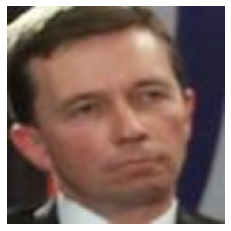

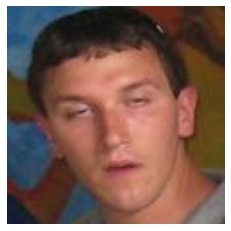

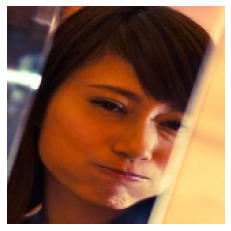

In [ ]:
for imgs, labels in valid_ds.take(1):
  a, b, c = imgs[0]
  print(imgs.shape, labels.shape)
  tf.print(labels[0])
  show(a)
  show(b)
  show(c)

# 2. Model Architecture Implementation

In [ ]:
faceNet = tf.keras.models.load_model('./drive/My Drive/Models/keras-facenet/model/facenet_keras.h5')
faceNet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:
for layer in faceNet.layers:
  layer.trainable = False

In [ ]:
base_model = keras.models.Model(inputs=faceNet.input, outputs=faceNet.get_layer(name="Mixed_6a").output, name="facenet_base")
base_model.trainable = False
base_model.summary()

Model: "facenet_base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
_______________________________________________________________________________________

In [ ]:
def conv_block(x, growth_rate, name):
  """A building block for a dense block.
  # Arguments
      x: input tensor.
      growth_rate: float, growth rate at dense layers.
      name: string, block label.
  # Returns
      Output tensor for the block.
  """
  x1 = layers.BatchNormalization(epsilon=1.001e-5,
                                  name=name + '_0_bn')(x)
  x1 = layers.ReLU(max_value=6., name=name + '_0_relu')(x1)
  x1 = layers.Dropout(0.5)(x1)
  x1 = layers.Conv2D(4 * growth_rate, 1,
                      use_bias=False,
                      name=name + '_1_conv')(x1)
  x1 = layers.BatchNormalization(epsilon=1.001e-5,
                                  name=name + '_1_bn')(x1)
  x1 = layers.ReLU(max_value=6., name=name + '_1_relu')(x1)
  x1 = layers.Dropout(0.5)(x1)
  x1 = layers.Conv2D(growth_rate, 3,
                      padding='same',
                      use_bias=False,
                      name=name + '_2_conv')(x1)
  x = layers.Concatenate(name=name + '_concat')([x, x1])
  return x

def dense_block(x, blocks, name, growth=64):
  """A dense block.
  # Arguments
      x: input tensor.
      blocks: integer, the number of building blocks.
      name: string, block label.
  # Returns
      output tensor for the block.
  """
  for i in range(blocks):
      x = conv_block(x, growth, name=name + '_block' + str(i + 1))
  return x

In [ ]:
def get_embeddings(input_tensor):
  x = base_model(input_tensor)
  x = keras.layers.Conv2D(512, 1, padding='same', use_bias=False)(x)
  x = dense_block(x, 5, name="dense1")
  x = keras.layers.BatchNormalization(epsilon=1.001e-5)(x)
  x = keras.layers.ReLU(max_value=6.)(x)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  x = keras.layers.Dense(512)(x)
  x = keras.layers.BatchNormalization(epsilon=1.001e-5)(x)
  x = keras.layers.ReLU(max_value=6.)(x)
  x = layers.Dropout(0.5)(x)
  x = keras.layers.Dense(16)(x)
  x = tf.math.l2_normalize(x, axis=-1)
  return x

In [ ]:
inputs = keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = get_embeddings(inputs)
feature_extractor = keras.Model(inputs, x, name="FEC_extractor")

In [ ]:
feature_extractor.summary()

Model: "FEC_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
facenet_base (Functional)       (None, 8, 8, 896)    2715472     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 512)    458752      facenet_base[0][0]               
__________________________________________________________________________________________________
dense1_block1_0_bn (BatchNormal (None, 8, 8, 512)    2048        conv2d_22[0][0]                  
______________________________________________________________________________________

In [ ]:
inputs = keras.layers.Input(shape=(3, IMG_HEIGHT, IMG_WIDTH, 3))

I1 = inputs[:,0,:,:,:]
I2 = inputs[:,1,:,:,:]
I3 = inputs[:,2,:,:,:]

e_I1 = tf.expand_dims(feature_extractor(I1), axis=1)
e_I2 = tf.expand_dims(feature_extractor(I2), axis=1)
e_I3 = tf.expand_dims(feature_extractor(I3), axis=1)

outs = tf.concat([e_I1, e_I2, e_I3], axis=1)

model = keras.models.Model(inputs=inputs, outputs=outs, name="FECNet")
model.summary()

Model: "FECNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 160, 160, 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 160, 160, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 160, 160, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 160, 160, 3) 0           input_2[0][0]                    
_____________________________________________________________________________________________

# 3. Loss Function And Metrics Utility Implementation

In [ ]:
class FECLoss(keras.losses.Loss):
  def __init__(
      self,
      reduction=keras.losses.Reduction.AUTO,
      name='loss',
      margin=0.1,
  ):
    super(FECLoss, self).__init__()
    self.margin = margin

  def call(self, labels, embeddings):

    margin_weights = tf.reshape(tf.cast(labels[:,3], tf.float32), (-1,))
    self.margin = tf.multiply(0.1, margin_weights)
    
    ## embeddings shape is (BATCH_SIZE, 3, EMBEDDING_SIZE)
    e_I1 = embeddings[:, 0, :]
    e_I2 = embeddings[:, 1, :]
    e_I3 = embeddings[:, 2, :]
    
    ## I1 & I2 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    
    loss3 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    ## I2 & I3 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I1), axis=-1)
    
    loss1 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    ## I1 & I3 are the most simmiliar pair
    d_pos = tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1)
    d_neg1 = tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1)
    d_neg2 = tf.reduce_sum(tf.square(e_I2 - e_I3), axis=-1)
    
    loss2 = tf.maximum(0., d_pos - d_neg1 + self.margin) + tf.maximum(0., d_pos - d_neg2 + self.margin)

    weights = tf.cast(labels[:,0:3], tf.float32)

    loss1 = tf.expand_dims(loss1,-1)
    loss2 = tf.expand_dims(loss2,-1)
    loss3 = tf.expand_dims(loss3,-1)

    loss = tf.reduce_sum(tf.concat([loss1,loss2,loss3], -1) * weights, axis=-1)

    # loss = tf.reduce_sum(loss)
    
    return loss

In [ ]:
class FECMetrics(keras.metrics.Metric):

    def __init__(self, name='accuracy', **kwargs):
      super(FECMetrics, self).__init__(name=name, **kwargs)
      self.accuracy = keras.metrics.Accuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):

      e_I1 = y_pred[:, 0, :]
      e_I2 = y_pred[:, 1, :]
      e_I3 = y_pred[:, 2, :]

      labels = tf.reshape(y_true[:, 0:3], (-1, 3))

      d12 = tf.expand_dims(tf.reduce_sum(tf.square(e_I1 - e_I2), axis=-1), axis=-1)
      d13 = tf.expand_dims(tf.reduce_sum(tf.square(e_I1 - e_I3), axis=-1), axis=-1)
      d23 = tf.expand_dims(tf.reduce_sum(tf.square(e_I3 - e_I2), axis=-1), axis=-1)

      distances = tf.concat([d23, d13, d12], axis=-1)

      min_indices = tf.argmin(distances, axis=-1)
      true_labels = tf.argmax(labels, axis=-1)

      self.accuracy.update_state(min_indices, true_labels)


    def result(self):
      return self.accuracy.result()
      
    def reset_states(self):
      self.accuracy.reset_states()


# 4. Model Training

In [ ]:
num_train = TRAIN_SIZE
num_valid = VALIDATION_SIZE
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_valid)//BATCH_SIZE

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=FECLoss(), metrics=[FECMetrics()])

In [ ]:
model.evaluate(valid_ds, steps=2)

2/2 [==============================] - 1s 278ms/step - loss: 0.4020 - accuracy: 0.3662


[0.4020071029663086, 0.3662109375]

In [ ]:
initial_epoch = 0 

In [ ]:
latest = tf.train.latest_checkpoint('./drive/My Drive/Models/FEC/Checkpoints/m')
print(latest)
print(latest.split("_")[1])
initial_epoch = int(latest.split("_")[1])

./drive/My Drive/Models/FEC/Checkpoints/m/fecnet_94_0.81
94


In [ ]:
model.load_weights(latest)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./drive/My Drive/Models/FEC/Checkpoints/m/fecnet_{epoch}_{val_accuracy:.2f}',
        save_weights_only=True,
        monitor='loss',
        verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

history = model.fit(train_ds,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    initial_epoch=initial_epoch,
                    epochs=100,
                    validation_data=valid_ds,
                    validation_steps=validation_steps)

model.save("./drive/My Drive/Models/FEC/FEC-IRNet-21-8.h5")
model.save("./drive/My Drive/Models/FEC/FEC-IRNet-21-8")

In [ ]:
model.evaluate(valid_ds)